# **Importation du dataset à partir du Kaggle**

In [ ]:
! pip install kaggle


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
 mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/


In [ ]:
! kaggle datasets download mateuszbuda/lgg-mri-segmentation

 97% 692M/714M [00:04<00:00, 157MB/s]
100% 714M/714M [00:04<00:00, 171MB/s]


In [ ]:

! unzip lgg-mri-segmentation

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_9_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_13.tif  
  inflating: lgg-mri-segmentati

# **Importation des bibliothèques**

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import cv2
from skimage import io

import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.backend as K

import random
import glob
from sklearn.preprocessing import StandardScaler, normalize
from IPython.display import display

# **Importation et préparation des données**

In [ ]:
data = pd.read_csv('/content/lgg-mri-segmentation/kaggle_3m/data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

In [ ]:
data.head(10)


,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,NaN,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,NaN,0.0
3,TCGA_CS_4944,NaN,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,NaN,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,NaN,0.0
5,TCGA_CS_5395,2.0,4.0,2,2.0,NaN,3.0,2,3.0,1.0,1.0,3.0,5.0,2.0,43.0,2.0,NaN,1.0
6,TCGA_CS_5396,3.0,3.0,2,3.0,2.0,2.0,3,3.0,2.0,1.0,3.0,2.0,1.0,53.0,3.0,2.0,0.0
7,TCGA_CS_5397,NaN,4.0,1,2.0,3.0,3.0,2,1.0,2.0,1.0,1.0,6.0,1.0,54.0,3.0,2.0,1.0
8,TCGA_CS_6186,2.0,4.0,1,2.0,1.0,3.0,2,2.0,2.0,1.0,3.0,2.0,2.0,58.0,3.0,2.0,1.0
9,TCGA_CS_6188,2.0,4.0,3,2.0,3.0,3.0,2,1.0,2.0,1.0,3.0,6.0,2.0,48.0,3.0,2.0,0.0


In [ ]:
data_map = []
for sub_dir_path in glob.glob("/content/lgg-mri-segmentation/kaggle_3m/"+"*"):
    #if os.path.isdir(sub_path_dir):
    try:
        dir_name = sub_dir_path.split('/')[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + '/' + filename
            data_map.extend([dir_name, image_path])
    except Exception as e:
        print(e)

[Errno 20] Not a directory: '/content/lgg-mri-segmentation/kaggle_3m/data.csv'
[Errno 20] Not a directory: '/content/lgg-mri-segmentation/kaggle_3m/README.md'


In [ ]:
df = pd.DataFrame({"patient_id" : data_map[::2],
                   "path" : data_map[1::2]})
df.head()

,patient_id,path
0,TCGA_DU_7019_19940908,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...
1,TCGA_DU_7019_19940908,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...
2,TCGA_DU_7019_19940908,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...
3,TCGA_DU_7019_19940908,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...
4,TCGA_DU_7019_19940908,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...


In [ ]:
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]


In [ ]:
len(df_imgs)

3929

In [ ]:
BASE_LEN = 89
END_IMG_LEN = 4
END_MASK_LEN = 9

In [ ]:
imgs = sorted(df_imgs["path"].values, key=lambda x : x[BASE_LEN:-END_IMG_LEN])

In [ ]:
len(imgs)

3929

In [ ]:
masks = sorted(df_masks["path"].values, key=lambda x : x[BASE_LEN:-END_MASK_LEN])

In [ ]:
len(masks)

3929

In [ ]:
idx = random.randint(0, len(imgs)-1)

In [ ]:
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: /content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_3.tif 
Path to the Mask: /content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_32_mask.tif


**notre dataframe finale**

In [ ]:

brain_df = pd.DataFrame({"patient_id": df_imgs.patient_id.values,
                         "image_path": imgs,
                         "mask_path": masks
                        })
def pos_neg_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 :
        return 1
    else:
        return 0

brain_df['mask'] = brain_df['mask_path'].apply(lambda x: pos_neg_diagnosis(x))
brain_df

,patient_id,image_path,mask_path,mask
0,TCGA_DU_7019_19940908,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,0
1,TCGA_DU_7019_19940908,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,1
2,TCGA_DU_7019_19940908,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,0
3,TCGA_DU_7019_19940908,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,1
4,TCGA_DU_7019_19940908,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,0
...,...,...,...,...
3924,TCGA_CS_6188_20010812,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,0
3925,TCGA_CS_6188_20010812,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,0
3926,TCGA_CS_6188_20010812,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,0
3927,TCGA_CS_6188_20010812,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,0


# **Visualiisation des données**

In [ ]:
brain_df['mask'].value_counts()


0    2556
1    1373
Name: mask, dtype: int64

In [ ]:
import plotly.graph_objects as go

fig = go.Figure([go.Bar(x=brain_df['mask'].value_counts().index,
                        y=brain_df['mask'].value_counts(),
                        width=[.4, .4]
                       )
                ])
fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=4, opacity=0.4
                 )
fig.update_layout(title_text="Mask Count Plot",
                  width=700,
                  height=550,
                  yaxis=dict(
                             title_text="Count",
                             tickmode="array",
                             titlefont=dict(size=20)
                           )
                 )
fig.update_yaxes(automargin=True)
fig.show()

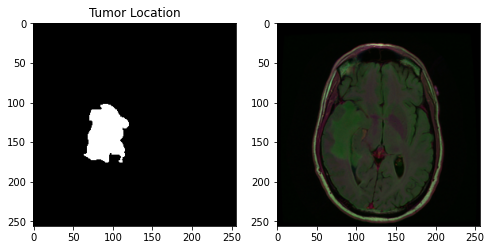

In [ ]:
for i in range(len(brain_df)):
    if cv2.imread(brain_df.mask_path[i]).max() > 0:
        break

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(cv2.imread(brain_df.mask_path[i]));
plt.title('Tumor Location')

plt.subplot(1,2,2)
plt.imshow(cv2.imread(brain_df.image_path[i]));

In [ ]:
cv2.imread(brain_df.mask_path[i]).max(), cv2.imread(brain_df.mask_path[i]).min()

(255, 0)

**Visualisation des images (IRM et masque) séparément dans l'ensemble de données**

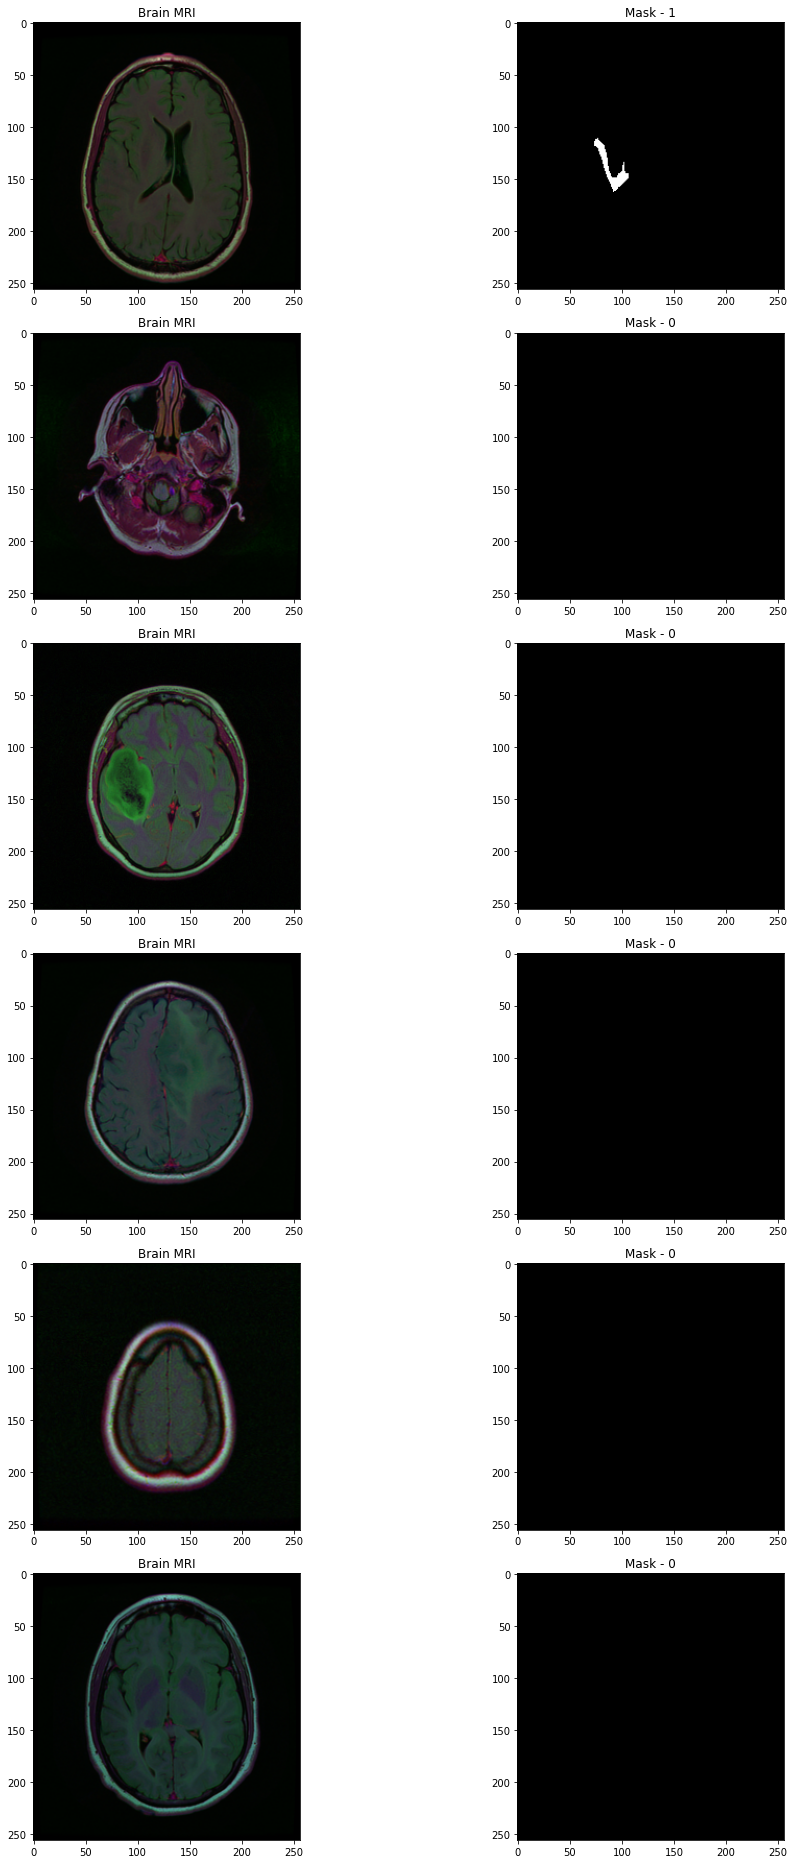

In [ ]:
fig, axs = plt.subplots(6,2, figsize=(16,26))
count = 0
for x in range(6):
  i = random.randint(0, len(brain_df)) # la sélection d'un index aléatoire
  axs[count][0].title.set_text("Brain MRI") # titre
  axs[count][0].imshow(cv2.imread(brain_df.image_path[i])) # Affichage du MRI
  axs[count][1].title.set_text("Mask - " + str(brain_df['mask'][i])) # tracer le titre sur le masque (0 ou 1)
  axs[count][1].imshow(cv2.imread(brain_df.mask_path[i])) # Affichage du masque correspondant
  count += 1

fig.tight_layout()

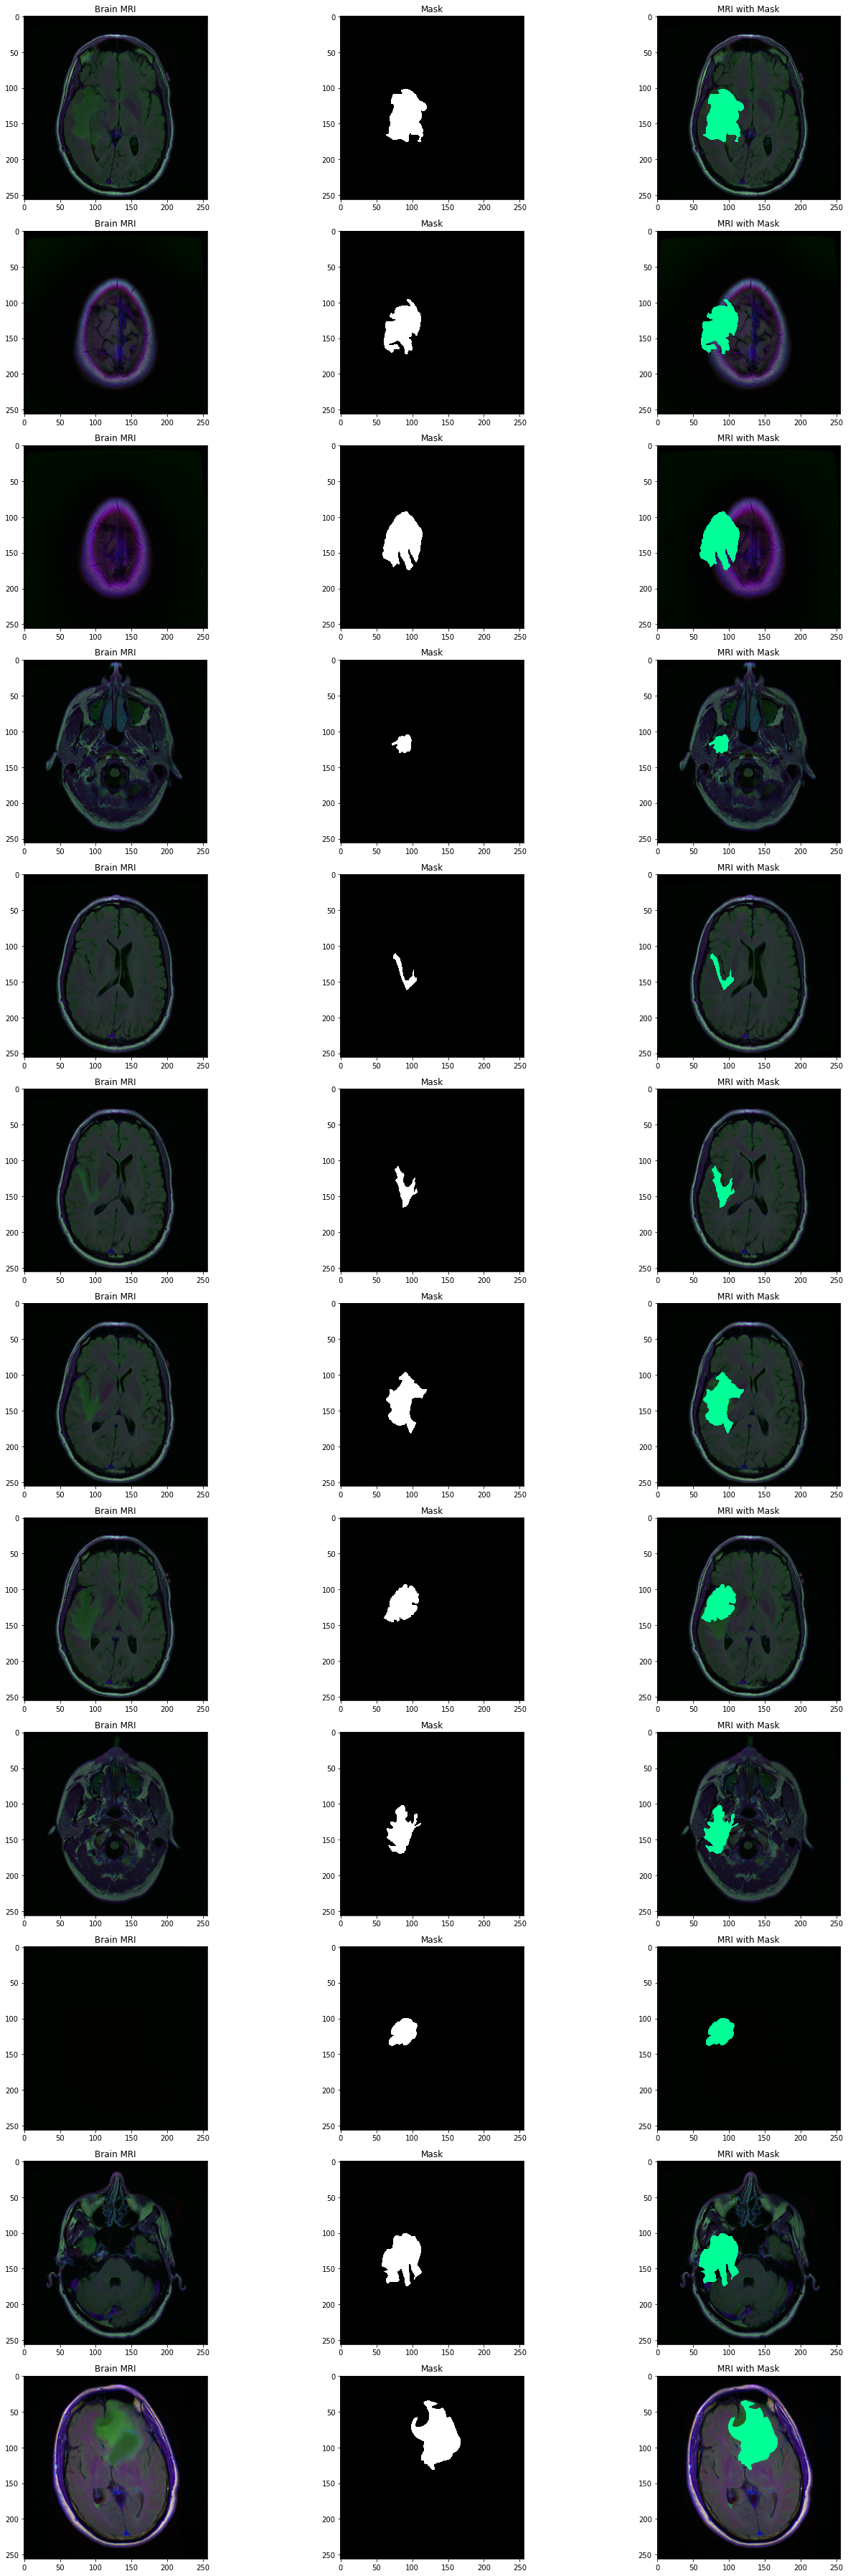

In [ ]:
count = 0
i = 0
fig,axs = plt.subplots(12,3, figsize=(20,50))
for mask in brain_df['mask']:
    if (mask==1):
        img = io.imread(brain_df.image_path[i])
        axs[count][0].title.set_text("Brain MRI")
        axs[count][0].imshow(img)

        mask = io.imread(brain_df.mask_path[i])
        axs[count][1].title.set_text("Mask")
        axs[count][1].imshow(mask, cmap='gray')

        img[mask==255] = (0,255,150)  # change pixel color at the position of mask
        axs[count][2].title.set_text("MRI with Mask")
        axs[count][2].imshow(img)
        count +=1
    i += 1
    if (count==12):
        break

fig.tight_layout()

# **Création de TEST, TRAIN et VAL SET**

In [ ]:
brain_df_train = brain_df.drop(columns=['patient_id'])
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(brain_df_train, test_size=0.15)

**Augmentation de la taille de data set avec ImageDataGenerator**

In [ ]:
from keras_preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255., validation_split=0.1)

train_generator = datagen.flow_from_dataframe(train,
                                              directory='./',
                                              x_col='image_path',
                                              y_col='mask',
                                              subset='training',
                                              class_mode='categorical',
                                              batch_size=16,
                                              shuffle=True,
                                              target_size=(256,256)
                                             )
valid_generator = datagen.flow_from_dataframe(train,
                                              directory='./',
                                              x_col='image_path',
                                              y_col='mask',
                                              subset='validation',
                                              class_mode='categorical',
                                              batch_size=16,
                                              shuffle=True,
                                              target_size=(256,256)
                                             )
test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_dataframe(test,
                                                  directory='./',
                                                  x_col='image_path',
                                                  y_col='mask',
                                                  class_mode='categorical',
                                                  batch_size=16,
                                                  shuffle=False,
                                                  target_size=(256,256)
                                                 )


Found 3006 validated image filenames belonging to 2 classes.
Found 333 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


# **La classification avec le modèle ResNet50**

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
clf_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(256,256,3)))
clf_model.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

In [ ]:
for layer in clf_model.layers:
    layers.trainable = False

In [ ]:
head = clf_model.output
head = AveragePooling2D(pool_size=(4,4))(head)
head = Flatten(name='Flatten')(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.3)(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.3)(head)
head = Dense(2, activation='softmax')(head)

model = Model(clf_model.input, head)
model.compile(loss = 'categorical_crossentropy',
              optimizer='adam',
              metrics= ["accuracy"]
             )
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=15
                             )
checkpointer = ModelCheckpoint(filepath="clf-resnet-weights.hdf5",
                               verbose=1,
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )
callbacks = [checkpointer, earlystopping, reduce_lr]

In [ ]:
h = model.fit(train_generator,
              steps_per_epoch= train_generator.n // train_generator.batch_size,
              epochs = 60,
              validation_data= valid_generator,
              validation_steps= valid_generator.n // valid_generator.batch_size,
              callbacks=[checkpointer, earlystopping])

Epoch 1/60
187/187 [==============================] - ETA: 0s - loss: 0.8808 - accuracy: 0.6341
Epoch 1: val_loss improved from inf to 0.66099, saving model to clf-resnet-weights.hdf5
187/187 [==============================] - 63s 253ms/step - loss: 0.8808 - accuracy: 0.6341 - val_loss: 0.6610 - val_accuracy: 0.6313
Epoch 2/60
187/187 [==============================] - ETA: 0s - loss: 0.6489 - accuracy: 0.6552
Epoch 2: val_loss did not improve from 0.66099
187/187 [==============================] - 44s 237ms/step - loss: 0.6489 - accuracy: 0.6552 - val_loss: 0.6615 - val_accuracy: 0.6281
Epoch 3/60
187/187 [==============================] - ETA: 0s - loss: 0.6462 - accuracy: 0.6538
Epoch 3: val_loss improved from 0.66099 to 0.65695, saving model to clf-resnet-weights.hdf5
187/187 [==============================] - 46s 246ms/step - loss: 0.6462 - accuracy: 0.6538 - val_loss: 0.6570 - val_accuracy: 0.6375
Epoch 4/60
187/187 [==============================] - ETA: 0s - loss: 0.6465 - accu

**Enregistrement de l'architecture du modèle dans un fichier json**

In [ ]:

model_json = model.to_json()
with open("clf-resnet-model.json", "w") as json_file:
    json_file.write(model_json)

**L'évaluation du modèle de classification ResNet50**

In [ ]:
h.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

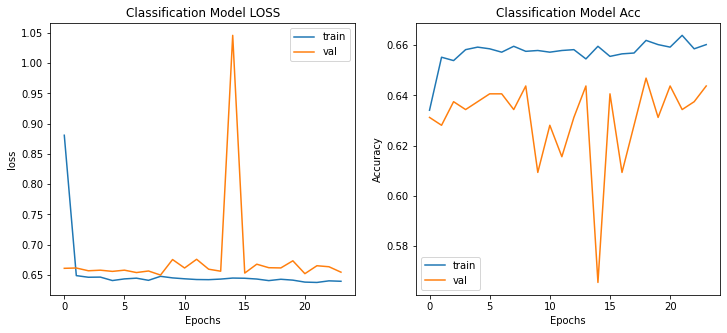

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(h.history['loss']);
plt.plot(h.history['val_loss']);
plt.title("Classification Model LOSS");
plt.ylabel("loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(h.history['accuracy']);
plt.plot(h.history['val_accuracy']);
plt.title("Classification Model Acc");
plt.ylabel("Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

In [ ]:
_, acc = model.evaluate(test_generator)
print("Test accuracy : {} %".format(acc*100))

37/37 [==============================] - 3s 75ms/step - loss: 0.6768 - accuracy: 0.5983
Test accuracy : 59.83051061630249 %


37/37 [==============================] - 3s 70ms/step
0.5983050847457627
              precision    recall  f1-score   support

           0       0.60      0.99      0.75       354
           1       0.33      0.00      0.01       236

    accuracy                           0.60       590
   macro avg       0.47      0.50      0.38       590
weighted avg       0.49      0.60      0.45       590



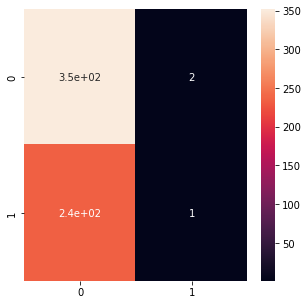

In [ ]:
prediction = model.predict(test_generator)

pred = np.argmax(prediction, axis=1)
original = np.asarray(test['mask']).astype('int')

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy = accuracy_score(original, pred)
print(accuracy)

cm = confusion_matrix(original, pred)

report = classification_report(original, pred, labels = [0,1])
print(report)
plt.figure(figsize = (5,5))
sns.heatmap(cm, annot=True);

# **La classification avec le modèle VGG16**

In [ ]:

from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.interpolation import map_coordinates


def elastic_transform(image, alpha_range, sigma, random_state=None):

    if random_state is None:
        random_state = np.random.RandomState(None)

    if np.isscalar(alpha_range):
        alpha = alpha_range
    else:
        alpha = np.random.uniform(low=alpha_range[0], high=alpha_range[1])

    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha

    x, y, z = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), np.arange(shape[2]), indexing='ij')
    indices = np.reshape(x+dx, (-1, 1)), np.reshape(y+dy, (-1, 1)), np.reshape(z, (-1, 1))

    transformed_images = map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)

    return transformed_images

In [ ]:
from tensorflow.keras.applications import VGG16

pretrained_base = VGG16(weights="imagenet", include_top=False,input_tensor=Input(shape=(256,256,3)))
pretrained_base.summary()

pretrained_base.trainable = False

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                              

In [ ]:
from tensorflow import keras
from tensorflow.python.keras import Sequential



from tensorflow.keras import layers


model = keras.Sequential([


    pretrained_base,


    layers.Flatten(name='Flatten'),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid'),
])

In [ ]:
earlystopping = EarlyStopping(monitor='val_loss',
                              min_delta=0.001,
                              mode='min',
                              verbose=1,
                              patience=20,
                              restore_best_weights = True
                             )

checkpointer = ModelCheckpoint(filepath="vgg16_1.h5",
                               monitor = 'val_accuracy',
                               verbose=1,
                               save_best_only=True
                              )

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=15,
                              min_delta=0.0001,
                              factor=0.2
                             )

callbacks = [checkpointer, earlystopping, reduce_lr]

In [ ]:
model.compile(loss = 'binary_crossentropy',
              optimizer='adam',
              metrics= ['accuracy']
             )

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 Flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense_3 (Dense)             (None, 256)               8388864   
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 2

In [ ]:
h = model.fit(train_generator,
              steps_per_epoch= train_generator.n // train_generator.batch_size,
              epochs = 50,
              validation_data= valid_generator,
              validation_steps= valid_generator.n // valid_generator.batch_size,
              callbacks=[checkpointer, earlystopping])

Epoch 1/50
187/187 [==============================] - ETA: 0s - loss: 0.7480 - accuracy: 0.5000
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to vgg16_1.h5
187/187 [==============================] - 26s 127ms/step - loss: 0.7480 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/50
187/187 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5000
Epoch 2: val_accuracy did not improve from 0.50000
187/187 [==============================] - 22s 116ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/50
187/187 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5000
Epoch 3: val_accuracy did not improve from 0.50000
187/187 [==============================] - 22s 116ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/50
187/187 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5000
Epoch 4: val_accuracy did not im

**L'évaluation du modèle VGG16**

In [ ]:
model_json = model.to_json()
with open("clf-VGG16-model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
h.history.keys()

dict_keys(['loss', 'tversky', 'val_loss', 'val_tversky', 'lr'])

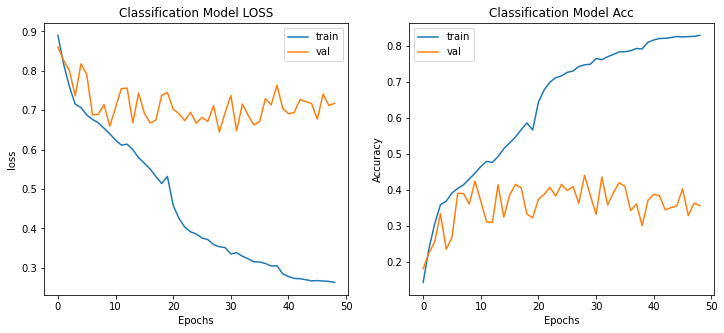

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(h.history['loss']);
plt.plot(h.history['val_loss']);
plt.title("Classification Model LOSS");
plt.ylabel("loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(h.history['tversky']);
plt.plot(h.history['val_tversky']);
plt.title("Classification Model Acc");
plt.ylabel("Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

In [ ]:
_, acc = model.evaluate(test_generator)
print("Test accuracy : {} %".format(acc*100))

37/37 [==============================] - 4s 99ms/step - loss: 0.6931 - accuracy: 0.5000
Test accuracy : 50.0 %


# **Modèle de segmentation : RESUNET**

In [ ]:
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.shape

**Creation de test, train et val sets**

In [ ]:

X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)
print("Train size is {}, valid size is {} & test size is {}".format(len(X_train), len(X_val), len(X_test)))

train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, ids , mask, image_dir = './', batch_size = 16, img_h = 256, img_w = 256, shuffle = True):

    self.ids = ids
    self.mask = mask
    self.image_dir = image_dir
    self.batch_size = batch_size
    self.img_h = img_h
    self.img_w = img_w
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):


    return int(np.floor(len(self.ids)) / self.batch_size)

  def __getitem__(self, index):


    indexes = self.indexes[index* self.batch_size : (index+1) * self.batch_size]

    list_ids = [self.ids[i] for i in indexes]

    list_mask = [self.mask[i] for i in indexes]


    X, y = self.__data_generation(list_ids, list_mask)

    return X, y

  def on_epoch_end(self):

    self.indexes = np.arange(len(self.ids))

    if self.shuffle:
      np.random.shuffle(self.indexes)

  def __data_generation(self, list_ids, list_mask):


    X = np.empty((self.batch_size, self.img_h, self.img_w, 3))
    y = np.empty((self.batch_size, self.img_h, self.img_w, 1))

    for i in range(len(list_ids)):
      img_path = str(list_ids[i])

      mask_path = str(list_mask[i])

      img = io.imread(img_path)
      mask = io.imread(mask_path)

      img = cv2.resize(img,(self.img_h,self.img_w))
      img = np.array(img, dtype = np.float64)

      mask = cv2.resize(mask,(self.img_h,self.img_w))
      mask = np.array(mask, dtype = np.float64)

      img -= img.mean()
      img /= img.std()

      mask -= mask.mean()
      mask /= mask.std()

      X[i,] = img

      y[i,] = np.expand_dims(mask, axis = 2)

    y = (y > 0).astype(int)

    return X, y

train_data = DataGenerator(train_ids, train_mask)
val_data = DataGenerator(val_ids, val_mask)


In [ ]:
def resblock(X, f):

    X_copy = X
    X = Conv2D(f, kernel_size=(1,1), kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    X = Conv2D(f, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)

    X_copy = Conv2D(f, kernel_size=(1,1), kernel_initializer='he_normal')(X_copy)
    X_copy = BatchNormalization()(X_copy)

    X = Add()([X, X_copy])
    X = Activation('relu')(X)

    return X

def upsample_concat(x, skip):

    X = UpSampling2D((2,2))(x)
    merge = Concatenate()([X, skip])

    return merge

In [ ]:
input_shape = (256,256,3)
X_input = Input(input_shape)


conv_1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(X_input)
conv_1 = BatchNormalization()(conv_1)
conv_1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv_1)
conv_1 = BatchNormalization()(conv_1)
pool_1 = MaxPool2D((2,2))(conv_1)

conv_2 = resblock(pool_1, 32)
pool_2 = MaxPool2D((2,2))(conv_2)

conv_3 = resblock(pool_2, 64)
pool_3 = MaxPool2D((2,2))(conv_3)

conv_4 = resblock(pool_3, 128)
pool_4 = MaxPool2D((2,2))(conv_4)

conv_5 = resblock(pool_4, 256)

up_1 = upsample_concat(conv_5, conv_4)
up_1 = resblock(up_1, 128)

up_2 = upsample_concat(up_1, conv_3)
up_2 = resblock(up_2, 64)

up_3 = upsample_concat(up_2, conv_2)
up_3 = resblock(up_3, 32)

up_4 = upsample_concat(up_3, conv_1)
up_4 = resblock(up_4, 16)

out = Conv2D(1, (1,1), kernel_initializer='he_normal', padding='same', activation='sigmoid')(up_4)

seg_model = Model(X_input, out)
seg_model.summary()


Entrainement de notre modèle de segmentation

In [ ]:
from keras.losses import binary_crossentropy

epsilon = 1e-5
smooth = 1

def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def focal_tversky(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate = 0.05, epsilon = 0.1)
seg_model.compile(optimizer = adam,
                  loss = focal_tversky,
                  metrics = [tversky]
                 )
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=20
                             )
checkpointer = ModelCheckpoint(filepath="ResUNet-segModel-weights.hdf5",
                               verbose=1,
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )

In [ ]:
h = seg_model.fit(train_data,
                  epochs = 60,
                  validation_data = val_data,
                  callbacks = [checkpointer, earlystopping, reduce_lr]
                 )

Epoch 1/60
72/72 [==============================] - ETA: 0s - loss: 0.8898 - tversky: 0.1437
Epoch 1: val_loss improved from inf to 0.86037, saving model to ResUNet-segModel-weights.hdf5
72/72 [==============================] - 19s 207ms/step - loss: 0.8898 - tversky: 0.1437 - val_loss: 0.8604 - val_tversky: 0.1816 - lr: 0.0500
Epoch 2/60
72/72 [==============================] - ETA: 0s - loss: 0.8162 - tversky: 0.2368
Epoch 2: val_loss improved from 0.86037 to 0.82587, saving model to ResUNet-segModel-weights.hdf5
72/72 [==============================] - 15s 201ms/step - loss: 0.8162 - tversky: 0.2368 - val_loss: 0.8259 - val_tversky: 0.2250 - lr: 0.0500
Epoch 3/60
72/72 [==============================] - ETA: 0s - loss: 0.7596 - tversky: 0.3063
Epoch 3: val_loss improved from 0.82587 to 0.80042, saving model to ResUNet-segModel-weights.hdf5
72/72 [==============================] - 14s 198ms/step - loss: 0.7596 - tversky: 0.3063 - val_loss: 0.8004 - val_tversky: 0.2563 - lr: 0.0500
Ep

In [ ]:
seg_model_json = seg_model.to_json()
with open("ResUNet-seg-model.json", "w") as json_file:
    json_file.write(seg_model_json)

**Evaluation de la performence de notre modèle de segmentation**


In [ ]:
h.history.keys()

dict_keys(['loss', 'tversky', 'val_loss', 'val_tversky', 'lr'])

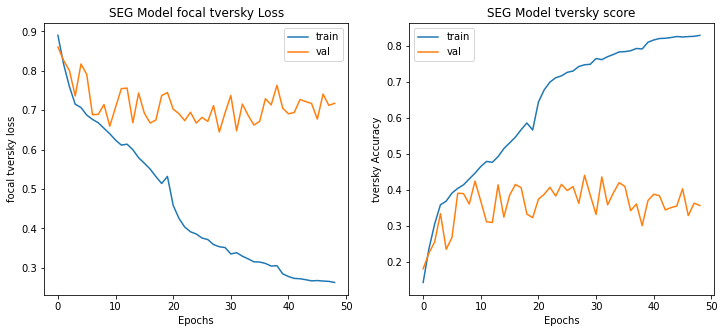

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(h.history['loss']);
plt.plot(h.history['val_loss']);
plt.title("SEG Model focal tversky Loss");
plt.ylabel("focal tversky loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(h.history['tversky']);
plt.plot(h.history['val_tversky']);
plt.title("SEG Model tversky score");
plt.ylabel("tversky Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

In [ ]:
test_ids = list(X_test.image_path)
test_mask = list(X_test.mask_path)
test_data = DataGenerator(test_ids, test_mask)
_, tv = seg_model.evaluate(test_data)
print("Segmentation tversky is {:.2f}%".format(tv*100))

6/6 [==============================] - 1s 95ms/step - loss: 0.7363 - tversky: 0.3337
Segmentation tversky is 33.37%


In [ ]:
def prediction(test, model, model_seg):

    mask, image_id, has_mask = [], [], []

    for i in test.image_path:

        img = io.imread(i)
        img = img *1./255.
        img = cv2.resize(img, (256,256))
        img = np.array(img, dtype=np.float64)
        img = np.reshape(img, (1,256,256,3))

        is_defect = model.predict(img)

        if np.argmax(is_defect)==0:
            image_id.append(i)
            has_mask.append(0)
            mask.append('No mask :)')
            continue

        X = np.empty((1,256,256,3))
        img = io.imread(i)
        img = cv2.resize(img, (256,256))
        img = np.array(img, dtype=np.float64)

        img -= img.mean()
        img /= img.std()
        X[0,] = img

        predict = model_seg.predict(X)

        if predict.round().astype(int).sum()==0:
            image_id.append(i)
            has_mask.append(0)
            mask.append('No mask :)')
        else:
            image_id.append(i)
            has_mask.append(1)
            mask.append(predict)

    return pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})


**fusion de l'original et la prédiction df**

In [ ]:
df_pred = prediction(test, model, seg_model)
df_pred

1/1 [==============================] - 0s 23ms/step


,image_path,predicted_mask,has_mask
0,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,No mask :),0
1,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,No mask :),0
2,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,No mask :),0
3,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,No mask :),0
4,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,No mask :),0
...,...,...,...
585,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,No mask :),0
586,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,No mask :),0
587,/content/lgg-mri-segmentation/kaggle_3m/TCGA_F...,No mask :),0
588,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,No mask :),0


In [ ]:
df_pred = test.merge(df_pred, on='image_path')
df_pred.head(5)

,image_path,mask_path,mask,mask_path_x,mask_x,mask_path_y,mask_y,predicted_mask,has_mask
0,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,0,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,0,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,0,No mask :),0
1,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,1,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,1,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,1,No mask :),0
2,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,0,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,0,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,0,No mask :),0
3,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,1,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,1,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,1,No mask :),0
4,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,1,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,1,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,1,No mask :),0


**Visualisation de la prédiction**

In [ ]:
count = 0
fig, axs = plt.subplots(15,5, figsize=(30,70))

for i in range(len(df_pred)):
    if df_pred.has_mask[i]==1 and count<15:
        img = io.imread(df_pred.image_path[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[count][0].imshow(img)
        axs[count][0].title.set_text('Brain MRI')

        #read masque original
        mask = io.imread(df_pred.mask_path[i])
        axs[count][1].imshow(mask)
        axs[count][1].title.set_text('Original Mask')

        #read masque prédit
        pred = np.array(df_pred.predicted_mask[i]).squeeze().round()
        axs[count][2].imshow(pred)
        axs[count][2].title.set_text('AI predicted mask')

        #superposer le masque d'origine avec l'IRM
        img[mask==255] = (255,0,0)
        axs[count][3].imshow(img)
        axs[count][3].title.set_text('Brain MRI with original mask (Ground Truth)')

        #superposer le masque prédit et l'IRM
        img_ = io.imread(df_pred.image_path[i])
        img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
        img_[pred==1] = (0,255,150)
        axs[count][4].imshow(img_)
        axs[count][4].title.set_text('MRI with AI PREDICTED MASK')

        count +=1
    if (count==15):
        break

fig.tight_layout()